In [0]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Progbar
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow import nn

In [0]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [0]:
# Loading data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [0]:
# Quantise the input data in q levels
q_levels = 2
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

In [0]:
# Creating input stream using tf.data API
batch_size = 192
train_buf = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

In [0]:
class VerticalConv2D(keras.layers.Conv2D):
    """https://github.com/JesseFarebro/PixelCNNPP/blob/master/layers/VerticalConv2D.py"""
    def __init__(self,
                 filters,
                 kernel_size,
                 **kwargs):
        if not isinstance(kernel_size, tuple):
            kernel_size = (kernel_size // 2 + 1, kernel_size)

        super(VerticalConv2D, self).__init__(filters, kernel_size, **kwargs)

        self.pad = tf.keras.layers.ZeroPadding2D(
            (
                (kernel_size[0] - 1, 0),  # Top, Bottom
                (kernel_size[1] // 2, kernel_size[1] // 2),  # Left, Right
            )
        )

    def call(self, inputs):
        inputs = self.pad(inputs)
        output = super(VerticalConv2D, self).call(inputs)

        return output


class HorizontalConv2D(keras.layers.Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 **kwargs):

        if not isinstance(kernel_size, tuple):
            kernel_size = (kernel_size // 2 + 1,) * 2

        super(HorizontalConv2D, self).__init__(filters, kernel_size, **kwargs)
        self.pad = tf.keras.layers.ZeroPadding2D(
            (
                (kernel_size[0] - 1, 0),  # (Top, Bottom)
                (kernel_size[1] - 1, 0),  # (Left, Right)
            )
        )

    def call(self, inputs):
        inputs = self.pad(inputs)
        outputs = super(HorizontalConv2D, self).call(inputs)

        return outputs

In [0]:
filters = 1
kernel_size = 3
vertical_conv = VerticalConv2D(filters=2 * filters,
                                            kernel_size=kernel_size)

In [0]:
vertical_conv.kernel_size


(2, 3)

In [0]:
class GatedBlock(tf.keras.Model):
    """ Gated block of the Gated PixelCNN."""

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_conv = VerticalConv2D(filters=2 * filters,
                                            kernel_size=kernel_size)
        

        if mask_type =='A':
            self.horizontal_conv = keras.layers.Conv2D(filters=2 * filters, 
                                          kernel_size=1)

        else:         
            self.horizontal_conv = HorizontalConv2D(filters=2 * filters,
                                                kernel_size=kernel_size)

        self.padding_A = keras.layers.ZeroPadding2D(padding=(0, (1,0)))
        self.cropping_A = keras.layers.Cropping2D(cropping=(0, (0, 1)))

        self.padding = keras.layers.ZeroPadding2D(padding=((1,0),0))
        self.cropping = keras.layers.Cropping2D(cropping=((0, 1), 0))

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v = input_tensor[0]
        h = input_tensor[1]

        vertical_preactivation = self.vertical_conv(v)  # NxN

        # Shifting feature map down to ensure causality
        v_to_h = self.padding(vertical_preactivation)
        v_to_h = self.cropping(v_to_h)
        v_to_h = self.v_to_h_conv(v_to_h)  # 1x1

        horizontal_preactivation = self.horizontal_conv(h)  # 1xN
        if self.mask_type == 'A':
            horizontal_preactivation = self.padding_A(horizontal_preactivation)
            horizontal_preactivation = self.cropping_A(horizontal_preactivation)
                
        
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out

In [0]:
# Create Gated PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=64, kernel_size=3)([inputs, inputs])

for i in range(7):
    v, h = GatedBlock(mask_type='B', filters=64, kernel_size=3)([v, h])

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=q_levels, kernel_size=1, strides=1)(x)

gated_pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Prepare optimizer and loss function
lr_decay = 0.999995
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(lr=learning_rate)

compute_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [0]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = gated_pixelcnn(batch_x, training=True)

        loss = compute_loss(tf.squeeze(tf.one_hot(batch_y, q_levels)), logits)

    gradients = ae_tape.gradient(loss, gated_pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, gated_pixelcnn.trainable_variables))

    return loss

In [0]:
# Training loop
n_epochs = 50
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[('loss', loss)])

Epoch 1/50
313/313 [==============================] - 167s 533ms/step - loss: 0.1132
Epoch 2/50
313/313 [==============================] - 160s 512ms/step - loss: 0.0888
Epoch 3/50
188/313 [=================>............]

KeyboardInterrupt: ignored

In [0]:
# Test set performance
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = gated_pixelcnn(batch_x, training=False)

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.squeeze(tf.one_hot(batch_y, q_levels)), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / np.log(2)))

nll : 0.08501224964857101 nats
bits/dim : 0.12264675098280793


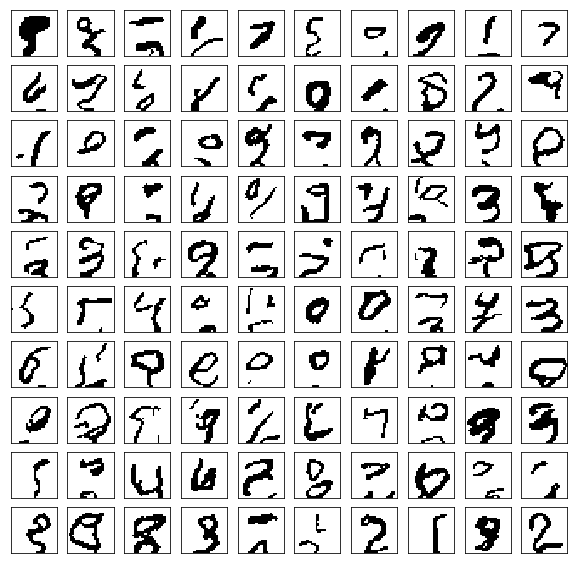

In [0]:
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = gated_pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

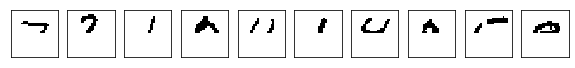

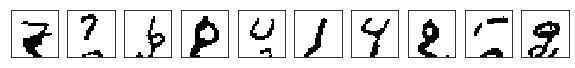

In [0]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = gated_pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()